In [106]:
import argparse
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from joblib import Parallel, delayed
import torch
from torch.distributions.normal import Normal
import torch.nn.functional as F

from collections import OrderedDict


from collections import OrderedDict
from utilities.meta_utils import tensors_to_device
import torch.nn.functional as F
import matplotlib.pyplot as plt

from learner.BasicLearner import BasicLearner
from learner.ResidualPerturbatedMAML import ResidualPerturbatedMAML
from network.meta_network import MetaNetworkWithPertubation, NoisyMetaNetwork, MetaNetwork
from task.TaskGenerator import SinTaskGenerator
from utilities.folder_management import handle_folder_creation


In [119]:
class NoisyMetaNetwork_IO(MetaNetwork):

    def __init__(self, n_in, n_out,
                 init_mean_w_output: torch.tensor, init_std_w_output: torch.tensor,
                 init_mean_b_output: torch.tensor, init_std_b_output: torch.tensor,
                 init_mean_w_input: torch.tensor, init_std_w_input: torch.tensor,
                 init_mean_b_input: torch.tensor, init_std_b_input: torch.tensor,
                 hidden_sizes=(),
                 nonlinearity=F.relu,
                 ):
        super(NoisyMetaNetwork_IO, self).__init__(n_in=n_in, n_out=n_out)
        self.hidden_sizes = hidden_sizes
        self.nonlinearity = nonlinearity
        self.num_layers = len(hidden_sizes) + 1

        layer_sizes = (n_in,) + hidden_sizes
        for i in range(1, self.num_layers):
            self.add_module('layer{0}'.format(i), torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i]))

        self.output_layer = torch.nn.Linear(layer_sizes[-1], n_out)

        # Perturbation stuff: noise layer and perturbation parameters
        self.add_module('noise_input', torch.nn.Linear(n_in, layer_sizes[1]))
        self.add_module('noise_output', torch.nn.Linear(layer_sizes[-1], n_out))

        p = OrderedDict(self.named_parameters())
        torch.nn.init.constant_(p['noise_input.weight'], 1)
        torch.nn.init.constant_(p['noise_input.bias'], 1)
        torch.nn.init.constant_(p['noise_output.weight'], 1)
        torch.nn.init.constant_(p['noise_output.bias'], 1)

        self.w_perturbation_dist_output = Normal(init_mean_w_output, init_std_w_output)
        self.b_perturbation_dist_output = Normal(init_mean_b_output, init_std_b_output)
        self.w_perturbation_dist_input = Normal(init_mean_w_input, init_std_w_input)
        self.b_perturbation_dist_input = Normal(init_mean_b_input, init_std_b_input)

    def forward(self, x, params=None, perturbation=False):
        if params is None:
            params = OrderedDict(self.named_parameters())

        for i in range(1, self.num_layers):
            if i == 1 and perturbation:
                standard_x = F.linear(x, weight=params['layer1.weight'], bias=params['layer1.bias'])
                
                samples_w = self.w_perturbation_dist_input.sample()
                samples_b = self.b_perturbation_dist_input.sample()
                new_w = params['noise_input.weight'] * samples_w
                new_b = params['noise_input.bias'] * samples_b
                pert_x = F.linear(x, weight=new_w, bias=new_b)

                x = standard_x + pert_x
                x = self.nonlinearity(x)
            else:
                x = F.linear(x, weight=params['layer{0}.weight'.format(i)], bias=params['layer{0}.bias'.format(i)])
                x = self.nonlinearity(x)

        if perturbation:
            standard_output = F.linear(x, weight=params['output_layer.weight'], bias=params['output_layer.bias'])

            samples_w = self.w_perturbation_dist_output.sample()
            new_w = params['noise_output.weight'] * samples_w

            samples_b = self.b_perturbation_dist_output.sample()
            new_b = params['noise_output.bias'] * samples_b

            pert_x = F.linear(x, weight=new_w, bias=new_b)
            x = standard_output + pert_x
        else:
            x = F.linear(x, weight=params['output_layer.weight'], bias=params['output_layer.bias'])

        return x

    def update_parameters(self, loss, params=None, step_size=0.5, first_order=False,
                          remove_noise_param=True):
        if params is None:
            params = OrderedDict(self.named_meta_parameters())

        if remove_noise_param:
            if params.__contains__('noise_output.bias'):
                del params['noise_output.bias']
            if params.__contains__('noise_output.weight'):
                del params['noise_output.weight']
            if params.__contains__('noise_input.bias'):
                del params['noise_input.bias']
            if params.__contains__('noise_input.weight'):
                del params['noise_input.weight']

        return super().update_parameters(loss=loss, params=params, step_size=step_size,
                                         first_order=first_order)

    def set_learn_net(self, state=True):
        params = OrderedDict(self.named_meta_parameters())
        for key in params:
            if key not in ['noise_output.weight', 'noise_output.bias', 'noise_input.weight', 'noise_input.bias']:
                params[key].requires_grad = state

    def set_learn_noise(self, state=True):
        params = OrderedDict(self.named_meta_parameters())
        params['noise_output.weight'].requires_grad = state
        params['noise_output.bias'].requires_grad = state
        params['noise_input.weight'].requires_grad = state
        params['noise_input.bias'].requires_grad = state

    def set_noise_layer(self, new_params):
        curr_params = OrderedDict(self.named_meta_parameters())
        curr_params['noise_output.weight'] = new_params['noise_output.weight']
        curr_params['noise_output.bias'] = new_params['noise_output.bias']
        curr_params['noise_input.weight'] = new_params['noise_input.weight']
        curr_params['noise_input.bias'] = new_params['noise_input.bias']

    def merge_parameters(self, params):
        curr_params = OrderedDict(self.named_meta_parameters())
        for key in curr_params:
            curr_params[key] += params[key]


In [120]:
# Network parameters
INPUT_SIZE = 1
OUTPUT_SIZE = 1
HIDDEN_SIZE = (64, 64, 64)

TRAINING_EPOCHS = 10
TEST_PERCENTAGE = 0.2

NET_LR = 0.01

# Meta parameters
FIRST_ORDER = False
RES_STOCHASTIC_ITERATION = 30
RES_LR = 0.001

# Dataset parameters
MIN_X = -5
MAX_X = 5

BATCH_SIZE = 128
LATER_BATCH_SIZE = 10

NUM_BATCH_FIRST_TASK = 1000
NUM_BATCH_LATER_TASK = 5

MAX_BATCHES_FIRST_TASK = 2000
MAX_BATCHES_LATER_TASK = 30

SIMULATE_MAX_BATCHES = 1000
SIMULATE_BATCH_SIZE = 32
SIMULATE_N_BATCHES = 250
SIMULATE_TEST_SPLIT = 0.2

# Task parameters
AMPLITUDE_LIST = [1, 1.4, 1.8, 2.2, 2.8, 3.2, 3.6, 4.0, 4.4, 4.0, 3.6, 3.2, 3.6, 3.2, 3.2, 2.8]
PHASE_LIST = [0, 0.3, 0.6, 0.8, 1.0, 1.3, 1.6, 1.3, 1.6, 1.3, 1.0, 1.5, 1.8, 1.4, 1.5, 1.3]
n_tasks = len(AMPLITUDE_LIST)

In [121]:
task_generator: SinTaskGenerator = SinTaskGenerator(x_min=MIN_X, x_max=MAX_X)
device = "cpu"

init_mean_w_output = torch.zeros(HIDDEN_SIZE[-1], device=device)
init_std_w_output = 0.1*torch.ones(HIDDEN_SIZE[-1], device=device)
init_mean_b_output = torch.zeros(OUTPUT_SIZE, device=device)
init_std_b_output = 0.1*torch.ones(OUTPUT_SIZE, device=device)

init_mean_w_input = torch.zeros(HIDDEN_SIZE[0], device=device)
init_std_w_input = 0.1*torch.ones(HIDDEN_SIZE[0], device=device)
init_mean_b_input = torch.zeros(HIDDEN_SIZE[0], device=device)
init_std_b_input = 0.1*torch.ones(HIDDEN_SIZE[0], device=device)

init_input_mean = torch.zeros(1, device=device)
init_input_std = 0.3 * torch.ones(1, device=device)

task_0_net: torch.nn.Module = NoisyMetaNetwork_IO(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                               init_mean_w_output=init_mean_w_output, 
                                               init_std_w_output=init_std_w_output,
                                               init_mean_b_output=init_mean_b_output, 
                                               init_std_b_output=init_std_b_output,
                                               init_mean_w_input=init_mean_w_input.unsqueeze(1), 
                                               init_std_w_input=init_std_w_input.unsqueeze(1),
                                               init_mean_b_input=init_std_b_input,
                                               init_std_b_input=init_std_b_input
                                               )

residual_net: torch.nn.Module = NoisyMetaNetwork_IO(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                               init_mean_w_output=init_mean_w_output, 
                                               init_std_w_output=init_std_w_output,
                                               init_mean_b_output=init_mean_b_output, 
                                               init_std_b_output=init_std_b_output,
                                               init_mean_w_input=init_mean_w_input.unsqueeze(1), 
                                               init_std_w_input=init_std_w_input.unsqueeze(1),
                                               init_mean_b_input=init_std_b_input,
                                               init_std_b_input=init_std_b_input
                                               )

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(residual_net.parameters(), lr=0.1)
net_opt = torch.optim.Adam(task_0_net.parameters(), lr=0.01)
learner: ResidualPerturbatedMAML = ResidualPerturbatedMAML(network=task_0_net,
                                                           residual_network=residual_net,
                                                           n_in=INPUT_SIZE,
                                                           n_out=OUTPUT_SIZE,
                                                           net_optimizer=net_opt,
                                                           net_loss_function=loss,
                                                           maml_optimizer=optimizer,
                                                           maml_loss_function=loss,
                                                           net_scheduler=None,
                                                           x_space=task_generator.x_space,
                                                           device=device,
                                                           first_order=FIRST_ORDER,
                                                           learn_step_size=True)
                                                    

In [122]:
# Train first model
data_loader_task_0 = task_generator.get_data_loader(amplitude=AMPLITUDE_LIST[0], test_perc=0.2,phase=PHASE_LIST[0], num_batches=3000, batch_size=128)
learner.train(data_loader_task_0, 4000)

4001it [00:28, 141.63it/s, loss=0.0135]                          


In [123]:
def plot(task_generator, amplitude_list, phase_list, model, perturbation=False, p_iter=5,
        plot_true=False, legend=False, plot_res=False):
    x_points = task_generator.x_space
    
    if plot_true:
        i = 0
        for a, p in zip(amplitude_list, phase_list):
            y_points = a * torch.sin(x_points - p)
            plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
            i += 1
    
    if perturbation:
        for i in range(0, p_iter):
            if plot_res:
                y = model(task_generator.x_space[0].unsqueeze(1), perturbation=True).detach()
                y -= model(task_generator.x_space[0].unsqueeze(1), perturbation=False).detach()
            else:
                y = model(task_generator.x_space[0].unsqueeze(1), perturbation=perturbation).detach()
            plt.plot(x_points[0],y, label="Net {}".format(i))
    else:
        plt.plot(x_points[0], model(task_generator.x_space[0].unsqueeze(1), perturbation=perturbation).detach(), label="Net")
    
    if legend:
        plt.legend()
    plt.show()

In [124]:
def plot_model_list(task_generator, amplitude_list, phase_list, model_list, plot_true=False):
    x_points = task_generator.x_space
    
    if plot_true:
        i = 0
        for a, p in zip(amplitude_list, phase_list):
            y_points = a * torch.sin(x_points - p)
            plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
            i += 1
    
    for i in range(len(model_list)):
        plt.plot(x_points[0], model_list[i](task_generator.x_space[0].unsqueeze(1)).detach(), label="Net {}".format(i))
    
    plt.legend()
    plt.show()

In [125]:
def plot_model_sum(task_generator, amplitude_list, phase_list, model_1, model_2):
    x_points = task_generator.x_space
    
    i = 0
    for a, p in zip(amplitude_list, phase_list):
        y_points = a * torch.sin(x_points - p)
        plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
        i += 1
    
    p_1 = model_1(task_generator.x_space[0].unsqueeze(1)).detach()
    p_2 = model_2(task_generator.x_space[0].unsqueeze(1)).detach()
    plt.plot(x_points[0],p_1+p_2 , label="Net {}".format(i))
    plt.legend()
    plt.show()

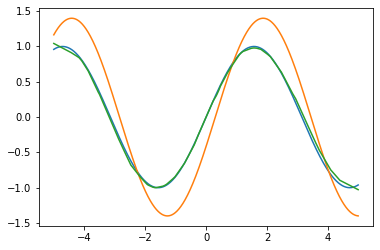

In [126]:
plot(task_generator,  AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], learner.network, perturbation=False, p_iter=100,
        plot_true=True, legend=False, plot_res=False)

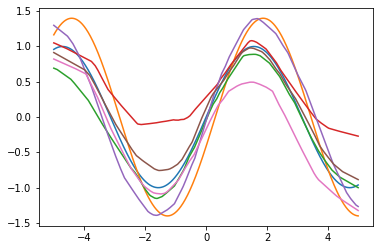

In [130]:
plot(task_generator,  AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], learner.network, perturbation=True, p_iter=5,
        plot_true=True, legend=False, plot_res=False)